<a href="https://colab.research.google.com/github/wittenator/pimai/blob/master/src/notebook/src/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  from google.colab import files
  !pip install torch torchvision skorch
  !pip install hypertools
  colab = True
except:
  pass

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from datetime import datetime

from multiprocessing import cpu_count

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset, DataLoader

from torch.distributions import *

import skorch
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline
#torch.autograd.set_detect_anomaly(True)

/usr/local/lib/python3.6/dist-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


## Dataset

In [5]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)

kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if use_cuda else {}
if not colab:
  train_loader = DataLoader(Subset(
      datasets.MNIST('/data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        #transforms.Normalize((0.1307,), (0.3081,))
                    ])), indices=range(1000)),
      batch_size=64, shuffle=True, **kwargs)
  test_loader = DataLoader(Subset(
      datasets.MNIST('/data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        #transforms.Normalize((0.1307,), (0.3081,))
                    ])), indices=range(1000)),
      batch_size=1000, shuffle=True, **kwargs)
else:
  train_loader = DataLoader(
      datasets.MNIST('/data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        #transforms.Normalize((0.1307,), (0.3081,))
                    ])),
      batch_size=128, shuffle=True, **kwargs)
  test_loader = DataLoader(
      datasets.MNIST('/data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        #transforms.Normalize((0.1307,), (0.3081,))
                    ])),
      batch_size=1000, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

True


9920512it [00:00, 20222121.16it/s]                            


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


32768it [00:00, 318733.76it/s]                           
0it [00:00, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw


1654784it [00:00, 5260890.97it/s]                           
8192it [00:00, 129808.79it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw
Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...
Done!


## Generic autoencoder class

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        now = datetime.now()
        current_time = now.strftime("%Y%m%d-%H%M%S")
        self.writer = SummaryWriter(log_dir="/data/runs/"+current_time)
        self.embeddings = []
        self.embedding_labels =[]
    
    def trains(self, device, train_loader, optimizer, epoch):
        self.train()
        loss_sum = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = self.compute_loss_train(data, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            self.writer.add_scalar('Loss/train', loss.item(), epoch*len(train_loader)+batch_idx)
            
    def tests(self, device, test_loader):
        self.eval()
        test_loss = 0
        recon = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                loss, output = self.compute_loss_test(data, target)
                test_loss += loss
                recon += F.binary_cross_entropy_with_logits(output, data.view(-1, 784), reduction='none').sum(axis=1).mean()

        test_loss /= len(test_loader.dataset)
        recon /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Reconstruction error: {}\n'.format(
            test_loss, recon))
        
    def add_embedding(self, loader):
        with torch.no_grad():
            labels = []
            embs = []
            for data, label in loader:
                data, label = data.to(device), label.to(device)
                labels.append(label)
                recon_batch, a, b = self(data)
                emb = self.reparameterize(a,b)
                embs.append(emb)
            self.embeddings.append(torch.cat(tuple(embs), dim=0).cpu().numpy())
            self.embedding_labels = torch.cat(tuple(labels), dim=0).cpu().numpy()
            
    def visualize_embeddings(self, epoch):
        hyp.plot(self.embeddings[epoch], '.', hue=self.embedding_labels, reduce='TSNE', ndims=2, save_path=f'/data/visualizations/{self.__class__.__name__}-{datetime.now().strftime("%Y%m%d-%H%M%S")}.svg' if not colab else None)

## Autoencoder

In [0]:
class SimpleAutoencoder(Autoencoder):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output       
    
    def compute_loss_train(self, data, target):
        output = self(data)
        return F.nll_loss(output, target)
    
    def compute_loss_test(self, data, target):
        output = self(data)
        return F.nll_loss(output, target, reduction='sum').item(), output  # sum up batch loss

In [6]:
model = SimpleAutoencoder().to(device)
optimizer = optim.Adadelta(model.parameters())

# plot model
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
#writer.add_image('mnist_images', img_grid)

scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 14 + 1):
    model.trains(device, train_loader, optimizer, epoch)
    model.tests(device, test_loader)
    scheduler.step()

KeyboardInterrupt: ignored

## Gaussian Variational Autoencoder

In [0]:
class VAE(Autoencoder):
    def __init__(self, k=20):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, k)
        self.fc22 = nn.Linear(400, k)
        self.fc3 = nn.Linear(k, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #x = self.conv1(x)
        #x = F.relu(x)
        #x = self.conv2(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
    
    def compute_loss_train(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar)
    
    def compute_loss_test(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar).item(), recon_batch  # sum up batch loss

In [8]:
vae = VAE(k=20).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 100 + 1):
    vae.trains(device, train_loader, optimizer, epoch)
    vae.tests(device, test_loader)
    vae.add_embedding(test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 35027.488281
Train Epoch: 1 [640/60000 (1%)]	Loss: 20700.480469
Train Epoch: 1 [1280/60000 (2%)]	Loss: 15516.031250
Train Epoch: 1 [1920/60000 (3%)]	Loss: 13900.803711
Train Epoch: 1 [2560/60000 (4%)]	Loss: 13259.400391
Train Epoch: 1 [3200/60000 (5%)]	Loss: 13729.707031
Train Epoch: 1 [3840/60000 (6%)]	Loss: 13595.680664
Train Epoch: 1 [4480/60000 (7%)]	Loss: 14173.146484
Train Epoch: 1 [5120/60000 (9%)]	Loss: 12887.438477
Train Epoch: 1 [5760/60000 (10%)]	Loss: 12705.598633
Train Epoch: 1 [6400/60000 (11%)]	Loss: 12423.821289
Train Epoch: 1 [7040/60000 (12%)]	Loss: 11915.857422
Train Epoch: 1 [7680/60000 (13%)]	Loss: 12301.501953
Train Epoch: 1 [8320/60000 (14%)]	Loss: 11360.177734
Train Epoch: 1 [8960/60000 (15%)]	Loss: 11116.173828
Train Epoch: 1 [9600/60000 (16%)]	Loss: 10552.029297
Train Epoch: 1 [10240/60000 (17%)]	Loss: 10959.989258
Train Epoch: 1 [10880/60000 (18%)]	Loss: 10915.225586
Train Epoch: 1 [11520/60000 (19%)]	Loss: 10341.576172
Tra

Exception in thread Thread-66:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

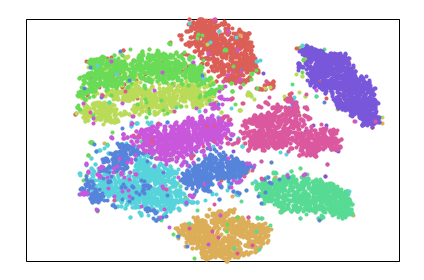

In [9]:
vae.visualize_embeddings(-1)

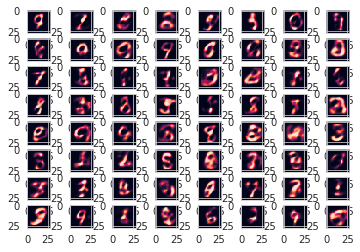

In [10]:
sample = torch.randn(64, 20).to(device)
sample = vae.decode(sample).reshape(64, 28, 28).cpu().detach().numpy()
f, axarr = plt.subplots(8,8)
for i in range(64):
  axarr[i//8,i%8].imshow(sample[i])

## Stick-breaking process

In [0]:
def stickbreakingprocess(a, b):
    eps = 10*torch.finfo(torch.float).eps
    batch_size = a.size()[0]
    
    uniform_samples = Uniform(torch.tensor([eps]), torch.tensor([1.0-eps])).rsample(a.size()).squeeze() if not use_cuda else torch.cuda.FloatTensor(a.size(0), a.size(1)).uniform_().clamp(eps, 1.0-eps)
    exp_a = torch.reciprocal(a)
    exp_b = torch.reciprocal(b)
    km = (1- uniform_samples.pow(exp_b) + eps).pow(exp_a)
    
    #no Nans are allowed in the matrix
    #assert not torch.isnan(km).any().item()
    
    cumprods = torch.cat((torch.ones([batch_size, 1], device=device), torch.cumprod(1-km, axis=1)), dim=1)
    sticks = cumprods[:,:-1]*km
    sticks[:, -1] = 1- sticks[:, :-1].sum(axis=1) 
    return sticks

In [10]:
stickbreakingprocess(torch.rand(10,20).to(device), torch.rand(10,20).to(device)).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

## Stick-breaking Autoencoder

In [0]:
class SBVAE(Autoencoder):
    def __init__(self, k):
        super(SBVAE, self).__init__()
        self.k = k
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 400)
        self.fc21 = nn.Linear(400, self.k)
        self.fc22 = nn.Linear(400, self.k)
        
        
        self.fc3 = nn.Linear(self.k, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return F.softplus(self.fc21(h1)), F.softplus(self.fc22(h1))

    def reparameterize(self, a, b):
        return stickbreakingprocess(a, b)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        a, b = self.encode(x)
        z = self.reparameterize(a, b)
        return self.decode(z), a, b
    
    def Beta(self, a,b):
        return torch.exp(torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b))
    
    def loss_function(self, recon_x, x, a, b, prior_alpha, prior_beta):
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none')
        ab = (a*b)
        kl = 1/(1+ab) * self.Beta(1/a, b)
        kl += 1/(2+ab) * self.Beta(2/a, b)
        kl += 1/(3+ab) * self.Beta(3/a, b)
        kl += 1/(4+ab) * self.Beta(4/a, b)
        kl += 1/(5+ab) * self.Beta(5/a, b)
        kl += 1/(6+ab) * self.Beta(6/a, b)
        kl += 1/(7+ab) * self.Beta(7/a, b)
        kl += 1/(8+ab) * self.Beta(8/a, b)
        kl += 1/(9+ab) * self.Beta(9/a, b)
        kl += 1/(10+ab) * self.Beta(10/a, b)
        kl *= (prior_beta-1)*b
                                                                                                                                            
        kl += (a-prior_alpha)/a * (-np.euler_gamma - torch.digamma(b) - 1/b) #T.psi(self.posterior_b)                                                                                        

        # add normalization constants                                                                                                                                                                
        kl += torch.log(ab) + torch.log(self.Beta(prior_alpha, prior_beta))

        # final term                                                                                                                                                                                 
        kl += -(b-1)/b 

        print(kl.sum().item(), BCE.sum().item())

        return len(train_loader)/a.size(0) * torch.mean(0.5*kl.sum(axis=1) + BCE.sum(axis=1))
    
    def compute_loss_train(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]).to(device), torch.Tensor([5]).to(device))
    
    def compute_loss_test(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]).to(device), torch.Tensor([5]).to(device)).item(), recon_batch 

In [20]:
sbvae = SBVAE(k=20).to(device)
optimizer = optim.Adam(sbvae.parameters(), lr=0.0003, betas=(0.95, 0.999))
#sbvae.writer.add_graph(sbvae, next(iter(train_loader))[0])


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 100 + 1): 
    sbvae.trains(device, train_loader, optimizer, epoch)
    sbvae.tests(device, test_loader)
    scheduler.step()
    sbvae.add_embedding(test_loader)

6212.2060546875 69648.6953125
Train Epoch: 1 [0/60000 (0%)]	Loss: 2082.641602
4874.087890625 69353.9609375
3612.444091796875 69063.578125
2578.2080078125 68777.6171875
2053.98876953125 68530.21875
2057.4345703125 68288.296875
1868.99658203125 67984.8984375
1534.293212890625 67727.578125
1220.0184326171875 67441.2734375
970.2702026367188 67135.515625
847.3671875 66862.2109375
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1926.091431
758.9462890625 66591.0
718.1513671875 66280.796875
706.9979858398438 66042.15625
668.4922485351562 65737.4296875
613.56640625 65470.484375
583.6403198242188 65207.578125
533.229736328125 64806.41015625
506.5859375 64632.1796875
498.38604736328125 64179.265625
484.76580810546875 63896.5234375
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1836.007568
520.5975341796875 63547.609375
586.0205078125 63172.1953125
678.387451171875 62662.9765625
818.0458984375 62131.73828125
1005.5661010742188 61849.8828125
1211.1787109375 61321.03515625
1453.126220703125 61170.2109375
1666.72839

KeyboardInterrupt: ignored

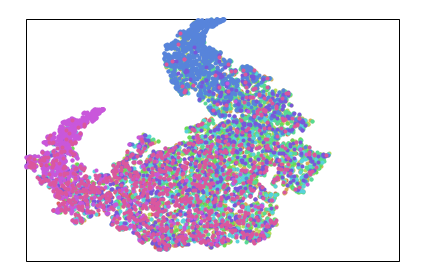

In [15]:
sbvae.visualize_embeddings(-1)

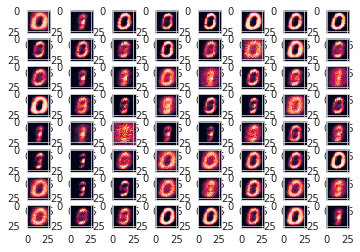

In [16]:
sample = torch.randn(64, 20).to(device)
sample = torch.sigmoid(sbvae.decode(sample)).reshape(64, 28, 28).cpu().detach().numpy()
f, axarr = plt.subplots(8,8)
for i in range(64):
  axarr[i//8,i%8].imshow(sample[i])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,